In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='microsoft/deberta-base'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'g':[]}

In [4]:
gamma = [2,4,8,16]
lr = 1.0e-5

for g in gamma:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=0.0,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       gamma=g,
                                                       accumulation_steps=2,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['g'].append(g)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search microsoft/deberta-base, learning rate 1e-05, focal loss gamma 2


Map:   0%|          | 0/1796 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.1726	Val Loss:	0.6810	Accuracy:	0.6543	F1:	0.6350
2 / 30: Train Loss:	0.1576	Val Loss:	0.5671	Accuracy:	0.7681	F1:	0.7052
3 / 30: Train Loss:	0.1249	Val Loss:	0.5174	Accuracy:	0.8140	F1:	0.7630
4 / 30: Train Loss:	0.0832	Val Loss:	0.4431	Accuracy:	0.8381	F1:	0.7920
5 / 30: Train Loss:	0.0535	Val Loss:	0.4184	Accuracy:	0.8228	F1:	0.7808
6 / 30: Train Loss:	0.0424	Val Loss:	0.5880	Accuracy:	0.7024	F1:	0.6865
7 / 30: Train Loss:	0.0341	Val Loss:	0.4634	Accuracy:	0.7834	F1:	0.7531
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.68      0.71      0.69       119
      struct       0.90      0.88      0.89       338

    accuracy                           0.84       457
   macro avg       0.79      0.80      0.79       457
weighted avg       0.84      0.84      0.84       457

test results:
              precision    recall  f1-score   support

       bknow

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0450	Val Loss:	0.7135	Accuracy:	0.2626	F1:	0.2099
2 / 30: Train Loss:	0.0424	Val Loss:	0.6646	Accuracy:	0.7505	F1:	0.4682
3 / 30: Train Loss:	0.0402	Val Loss:	0.6992	Accuracy:	0.3698	F1:	0.3551
4 / 30: Train Loss:	0.0383	Val Loss:	0.6555	Accuracy:	0.5492	F1:	0.5483
5 / 30: Train Loss:	0.0338	Val Loss:	0.6666	Accuracy:	0.5558	F1:	0.5541
6 / 30: Train Loss:	0.0300	Val Loss:	0.6133	Accuracy:	0.5558	F1:	0.5541
7 / 30: Train Loss:	0.0245	Val Loss:	0.5468	Accuracy:	0.7221	F1:	0.7015
8 / 30: Train Loss:	0.0177	Val Loss:	0.4244	Accuracy:	0.8249	F1:	0.7752
9 / 30: Train Loss:	0.0167	Val Loss:	0.4960	Accuracy:	0.7352	F1:	0.7103
10 / 30: Train Loss:	0.0125	Val Loss:	0.4579	Accuracy:	0.8031	F1:	0.7727
11 / 30: Train Loss:	0.0112	Val Loss:	0.5318	Accuracy:	0.6937	F1:	0.6786
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.66      0.68      0.67       119
      str

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0028	Val Loss:	0.6977	Accuracy:	0.3107	F1:	0.2789
2 / 30: Train Loss:	0.0028	Val Loss:	0.6619	Accuracy:	0.7637	F1:	0.7124
3 / 30: Train Loss:	0.0025	Val Loss:	0.6790	Accuracy:	0.6958	F1:	0.6653
4 / 30: Train Loss:	0.0023	Val Loss:	0.6535	Accuracy:	0.7155	F1:	0.6856
5 / 30: Train Loss:	0.0021	Val Loss:	0.6348	Accuracy:	0.7440	F1:	0.7061
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.54      0.66      0.59       119
      struct       0.87      0.80      0.83       338

    accuracy                           0.76       457
   macro avg       0.70      0.73      0.71       457
weighted avg       0.78      0.76      0.77       457

test results:
              precision    recall  f1-score   support

       bknow       0.51      0.63      0.56        67
      struct       0.86      0.78      0.82       189

    accuracy                           0.74    

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0000	Val Loss:	0.6960	Accuracy:	0.2735	F1:	0.2262
2 / 30: Train Loss:	0.0000	Val Loss:	0.6776	Accuracy:	0.7330	F1:	0.6821
3 / 30: Train Loss:	0.0000	Val Loss:	0.6786	Accuracy:	0.7637	F1:	0.6949
4 / 30: Train Loss:	0.0000	Val Loss:	0.6562	Accuracy:	0.7462	F1:	0.7071
5 / 30: Train Loss:	0.0000	Val Loss:	0.6759	Accuracy:	0.7352	F1:	0.7069
6 / 30: Train Loss:	0.0000	Val Loss:	0.6505	Accuracy:	0.7834	F1:	0.7404
7 / 30: Train Loss:	0.0000	Val Loss:	0.6691	Accuracy:	0.8206	F1:	0.7140
8 / 30: Train Loss:	0.0000	Val Loss:	0.6687	Accuracy:	0.7440	F1:	0.7082
9 / 30: Train Loss:	0.0000	Val Loss:	0.6638	Accuracy:	0.7177	F1:	0.6968
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.57      0.72      0.63       119
      struct       0.89      0.80      0.85       338

    accuracy                           0.78       457
   macro avg       0.73      0.76      0.74   

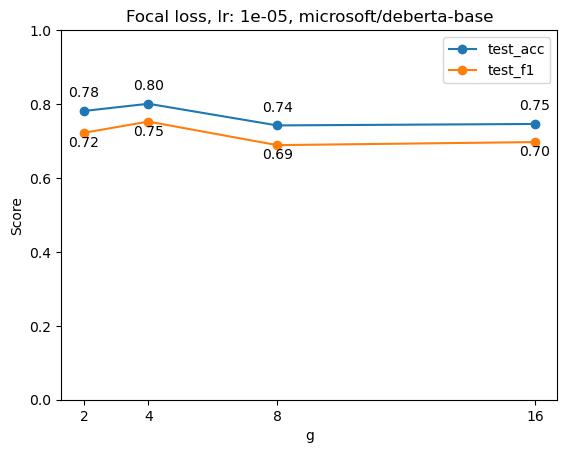

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Focal loss, lr: {lr}, {model_checkpoint}',
                        column='g',
                        sci_format=False)

In [6]:
%reset -f